## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import copy
import csv
from sklearn.utils import shuffle
from pandas.io.parsers import read_csv
%matplotlib inline

## Creation and exploration of the dataset

In [2]:
# Create a directory for the images of the writeup
info_dir_out = 'info_output/'
if not os.path.exists(info_dir_out):
    os.makedirs(info_dir_out)

The initial dataset has 8036 samples


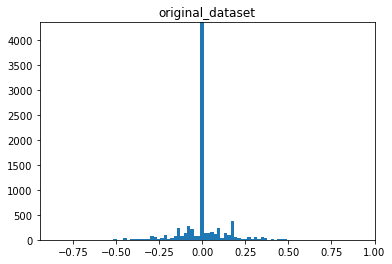

max value is 4361
min value is 1


In [3]:
def plot_histogram(data, title):
    # histogram of label frequency
    fig = plt.figure()
    unique_values, counts = np.unique(data, return_counts=True)
    plt.hist(data, bins=100)
    plt.title(title)
    plt.axis([min(data), max(data), 0, max(counts)])
    plt.show()
    print("max value is", max(counts))
    print("min value is", min(counts))
    
    #Save the histogram
    fig.savefig('info_output/' + 'Hist_'+title+'.jpg')
    
###Data exploration visualization

# Source Folder for the dataset of Udacity
samples_data = "udacity_data/"

# Read the initial dataset    
dataset_samples = read_csv(samples_data+"driving_log.csv", header=0, usecols=[0,1,2,3]).values;

print("The initial dataset has", len(dataset_samples), "samples")
plot_histogram(dataset_samples[:,3], 'original_dataset')

Here, it can be observed a very high peak for the data with 0 steering angle (4361 images) in comparison with the rest. In this section, the amount of 0 steering angle data is reduced to a value comparable with the rest of the classes.

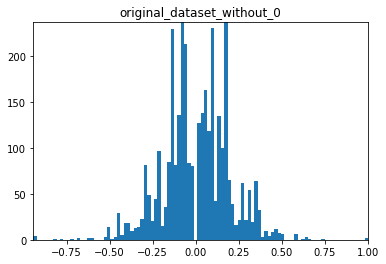

max value is 237
min value is 1


In [4]:
filtered_data = dataset_samples[abs(dataset_samples[:,3])>0.01]
plot_histogram(filtered_data[:,3], 'original_dataset_without_0')

The balanced dataset (peaks) has 3821 samples


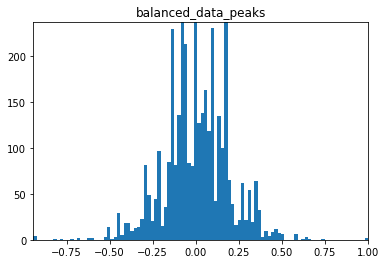

max value is 237
min value is 1


In [5]:
unique_values, counts = np.unique(filtered_data[:,3], return_counts=True)
max_value = max(counts)

peak_labels = dataset_samples[abs(dataset_samples[:,3])<0.01]
peak_labels = shuffle(peak_labels)
peak_labels = peak_labels[0:max_value, :]

dataset_balanced = np.concatenate((filtered_data, peak_labels))

print("The balanced dataset (peaks) has", len(dataset_balanced), "samples")
plot_histogram(dataset_balanced[:,3], 'balanced_data_peaks')


For this project, it was decided to use images of the 3 cameras (center, left and right), using a correction factor for the steering angles of 0.2 (0.2 for the left, -0.2 for the right)

The (unbalanced) full dataset has 11463 samples


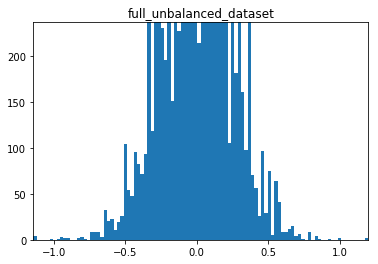

max value is 237
min value is 1


In [6]:
unbalanced_data = []
for line in dataset_balanced:
    new_line = copy.deepcopy(line)
    new_line[1] = line[3]
    unbalanced_data.append(new_line)

    new_line = copy.deepcopy(line)
    new_line[0] = new_line[1]
    new_line[1] = line[3] + 0.2
    unbalanced_data.append(new_line)
    
    new_line = copy.deepcopy(line)
    new_line[0] = new_line[2]
    new_line[1] = line[3] - 0.2
    unbalanced_data.append(new_line)

unbalanced_data = np.array(unbalanced_data)
unbalanced_data = unbalanced_data[:, 0:2]

print("The (unbalanced) full dataset has", len(unbalanced_data), "samples")
plot_histogram(unbalanced_data[:,1], 'full_unbalanced_dataset')

Through the tests carried out for network training ([write up](https://github.com/JKWalleiee/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup.md)), good results were obtained by reducing part of the data to balance the dataset. This balancing of the data can be observed in the following code cells.

Classes with more data than the calculated average value will be reduced to a factor (half for default) of the data.
The final balanced dataset has 5738 samples


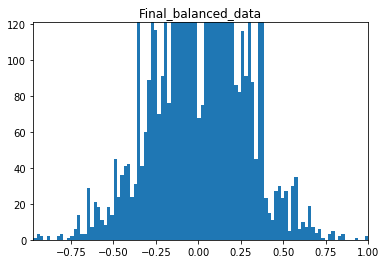

max value is 121
min value is 1


In [7]:
unique_values, counts = np.unique(unbalanced_data[:,1], return_counts=True)

# average value calculation
mean_data = int(np.mean(counts))

balanced_dataset = []

def extract_data(data, mean_data, divisor_factor = 2):
    if len(data) > mean_data:
        data = shuffle(data)
        new_size = int(len(data)/divisor_factor)
        data = data[0:new_size]
        
    for line in data:
        balanced_dataset.append(line)

def balance_data(dataset, step = 0.01):
    # select data for bin, with limits of bin + step
    # and balance the data for bin, if the size of the bin > average value
    print("Classes with more data than the calculated average value will be"+ 
          " reduced to a factor (half for default) of the data.")
    current_bin = 0.0
    while current_bin<1.0:
        data_vector = [data for data in dataset if (current_bin < abs(data[1])) 
                       and (abs(data[1])<=current_bin+step)]
        extract_data(data_vector, mean_data)
        current_bin = current_bin+step
    
balance_data(unbalanced_data)
balanced_dataset = np.array(balanced_dataset)
        
print("The final balanced dataset has", len(balanced_dataset), "samples")
plot_histogram((balanced_dataset[:,1]), 'Final_balanced_data');

In [8]:
writer = csv.writer(open("my_dataset.csv", 'w'))
i=0
writer.writerow(zip("features","labels"))
for row in balanced_dataset:
    writer.writerow(row)
    i = i +1
print(i," samples saved")

5738  samples saved


During the training phase, the image dataset is augmented, mainly for angles with an absolute value greater than 0.5 (where the classes lack data). Bellow it can be observed some of the samples of the training dataset (original, flipped and augmented (change brightness) )

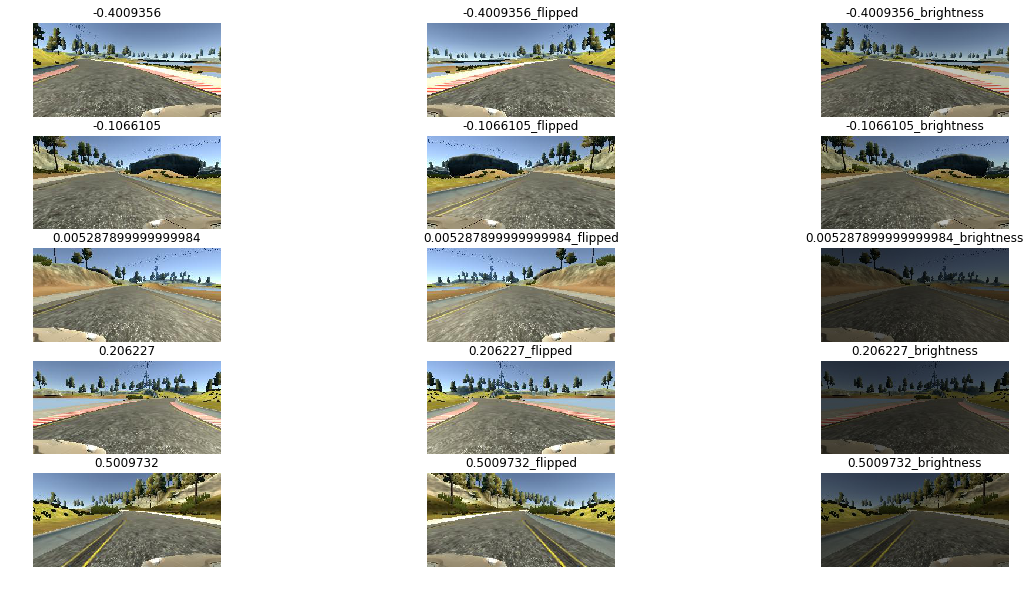

In [9]:
def image_brighten(image, base_change = 0.25):
    # change the brightness of the image, using a (random) 
    # multiplication factor
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    brightness = np.random.uniform(base_change, 1.0)
    hsv_image[:, :, 2] = hsv_image[:, :, 2] * brightness
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

def show_image_dataset(angles_vector):
    f, axes = plt.subplots(5, 3, figsize=(20,10))
    for it in range(len(angles_vector)):
        # read one image for the actual bin
        actual_bin = angles_vector[it]
        mask = [(balanced_dataset[:,1]>(actual_bin)) & (balanced_dataset[:,1]<(actual_bin+0.1))]
        image_path = balanced_dataset[mask][0,0]
        label_title = balanced_dataset[mask][0,1]
        image = cv2.imread(samples_data+image_path.strip())
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        #plot the initial and augmented images
        axes[it, 0].imshow(image)
        axes[it, 0].axis('off')
        axes[it, 0].set_title(str(label_title))
        
        flipped_image = cv2.flip(image, 1)
        axes[it, 1].imshow(flipped_image)
        axes[it, 1].axis('off')
        axes[it, 1].set_title(str(label_title)+"_flipped")
        
        augmented_image = image_brighten(image)
        axes[it, 2].imshow(augmented_image)
        axes[it, 2].axis('off')
        axes[it, 2].set_title(str(label_title)+"_brightness")

    #Save the image
    plt.savefig('info_output/' + 'dataset_exploration.jpg')

angles_vector = [-0.5, -0.2, 0.0, 0.2, 0.5]
show_image_dataset(angles_vector)

In addition, the CNN performs a process of cropping of the image, to receive only the important areas of the image. Below is an example of the result of this process, and what the CNN "sees".

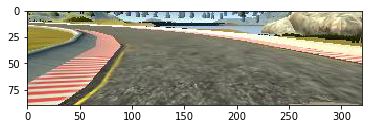

In [10]:
image_path = balanced_dataset[100,0]
label_title = balanced_dataset[100,1]
image = cv2.imread(samples_data+image_path.strip())
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

#This process is performed in one of the CNN layers. 
#Here it is performed outside the network for visualization reasons.
im_shape = image.shape
image = image[50:im_shape[0]-20, :]
fig = plt.figure()
plt.imshow(image)
plt.show()

#Save the image
fig.savefig('info_output/' + 'cropped_image.jpg')
